## DISCLAIMER AND WARNING: Because of the nature of this project, this report contains words that are very offensive. Needless to say, it is not the intention of the author of this report, and this project, to offend anybody.

# Feature Importance Analysis

## Table of Contents:
[1. Import Train and Test Set](#1.-Import-Train-and-Test-Set)
<br>[2. Feature Importance Analysis](#2.-Feature-Importance-Analysis)
<br>&emsp;&emsp;&emsp;[2.1. Logistic Regression with the Highest f1-Score](#2.1.-Logistic-Regression-with-the-Highest-f1-Score)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[2.1.1. Standardized Feature Importance of Logistic Regression](#2.1.1.-Standardized-Feature-Importance-of-Logistic-Regression)
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[2.1.2. SHAP of Logistic Regression](#2.1.2.-SHAP-of-Logistic-Regression)
<br>&emsp;&emsp;&emsp;[2.2. Logistic Regression with the Highest Recall Score](#2.2.-Logistic-Regression-with-the-Highest-Recall-Score)
<br>&emsp;&emsp;&emsp;[2.3. Random Forest](#2.3.-Random-Forest)
<br>&emsp;&emsp;&emsp;[2.4. XGBoost](#2.4.-XGBoost)

## 1. Introduction

In this notebook, two methods are employed to perform the feature importance analysis:
1- Interpretable models (Logistic Regression and Random Forest)
2- Interpretable machine learning methods (SHAP)

The interpretable machine learning methods are different from the interpretable models. Inherent interpretable models are based on how the model exactly functions. However, the interpretable machine learning methods use model-agnostic techniques to explain a model. These techniques assume the model as a black box and try to explain the relationship of features with the model predictions as an Additive Feature Attribution Method.

The interpretable machine learning method used in this study is SHapley Additive exPlanations (SHAP). SHAP is a game theoric approach to explain the output of machine learning models. SHAP interprets the predictions based on the calculation of Shapley values. 


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

import shap

sns.set_context('talk', rc={"grid.linewidth": 0.8})


/Users/zori/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 2. Import Train and Test Set

In [4]:
# import train dataset

df = pd.read_csv('Library/cleaned_text_train_df.csv')
df.head()

clean_text  toxic_type
0  explanation edit make username hardcore metall...           0
1  aww match background colour seemingly stuck th...           0
2  hey man really not try edit war guy constantly...           0
3  make real suggestion improvement wonder sectio...           0
4                      sir hero chance remember page           0

In [5]:
df.isna().sum()

clean_text    54
toxic_type     0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
# import test dataset

df_test = pd.read_csv('Library/cleaned_text_test_df.csv')
df_test.head()

clean_text  toxic_type
0  thank understand think highly would not revert...           0
1                             dear god site horrible           0
2  somebody invariably try add religion really me...           0
3  say right type type institution need case thre...           0
4  add new product list make sure relevant add ne...           0

In [8]:
df_test.isna().sum()

clean_text    437
toxic_type      0
dtype: int64

In [9]:
df_test = df_test.dropna()

In [10]:
df_test.head()

clean_text  toxic_type
0  thank understand think highly would not revert...           0
1                             dear god site horrible           0
2  somebody invariably try add religion really me...           0
3  say right type type institution need case thre...           0
4  add new product list make sure relevant add ne...           0

In [11]:
X_train = df['clean_text']
y_train = df['toxic_type']

X_test = df_test['clean_text']
y_test = df_test['toxic_type']


## 3. Feature Importance Analysis

### 3.1. Standardized Feature Importance of Logistic Regression

In [115]:
# Fit the tfidf and logistic regression model

tfidf_clf = TfidfVectorizer(max_features=24831)
tfidf_model_clf = tfidf_clf.fit(X_train)
X_train_vec_clf = tfidf_model_clf.transform(X_train).toarray()
X_test_vec_clf = tfidf_model_clf.transform(X_test).toarray()

clf = LogisticRegression(C=10.539293, solver='liblinear', n_jobs=-1)
clf.fit(X_train_vec_clf, y_train)

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


LogisticRegression(C=10.539293, n_jobs=-1, solver='liblinear')

In [116]:
# Extract the logistic regression coefficients and sort them

sort_id = clf.coef_.argsort()
feature_name_clf = tfidf_model_clf.get_feature_names_out()[sort_id].tolist()[0]
feature_importance_clf = clf.coef_[0][sort_id].tolist()[0]

In [117]:
# Standardize the coefficients

st_feat_imp = np.std(X_train_vec_clf, 0) * clf.coef_
standard_sort_id = st_feat_imp.argsort()
standard_feature_name = tfidf_model_clf.get_feature_names_out()[standard_sort_id].tolist()[0]
standard_feature_importance = st_feat_imp[0][standard_sort_id].tolist()[0]

In [13]:
# Copy the top 30 features for each class

standard_word = list()
standard_importance = list()

standard_word.extend(standard_feature_name[:30])
standard_word.extend(standard_feature_name[-30:])
standard_importance.extend(standard_feature_importance[:30])
standard_importance.extend(standard_feature_importance[-30:])

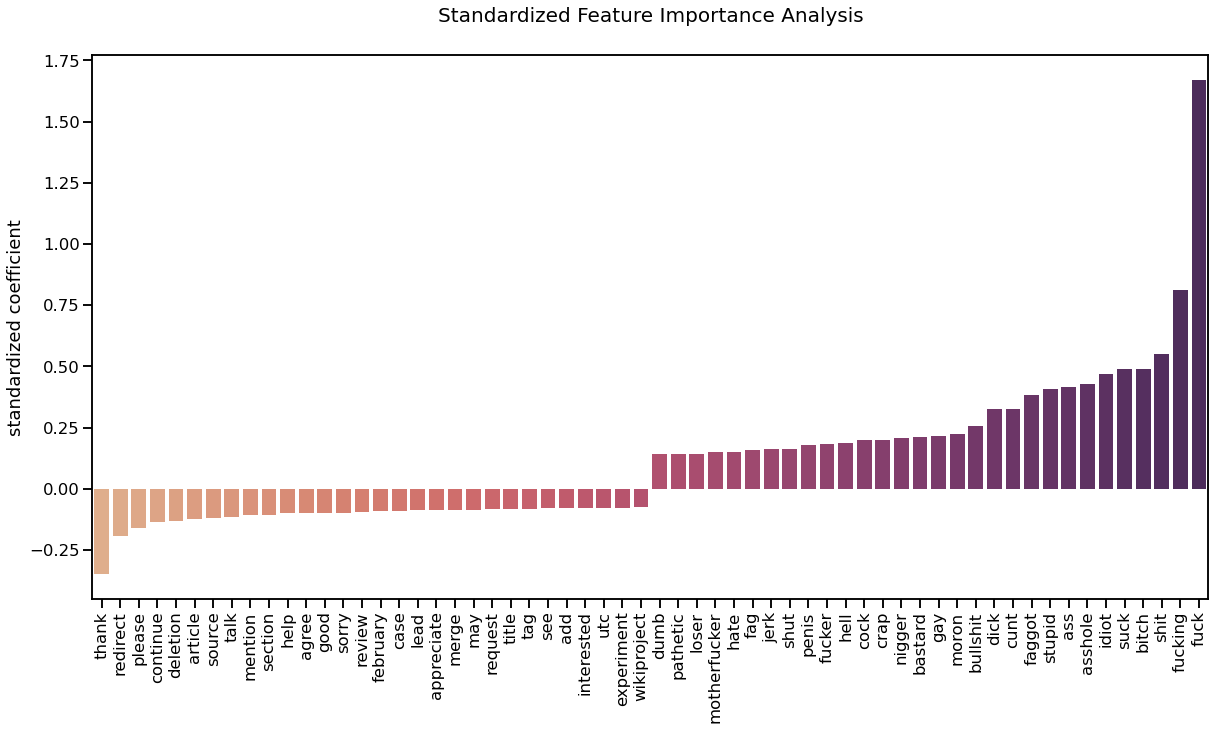

In [14]:
# Plot the top 30 features for both classes

fig = plt.figure(figsize=(20, 10))

# ax = fig.add_subplot(2,1,1)
ax = sns.barplot(x=standard_word, y=standard_importance, palette='flare')
plt.tick_params(axis='x', rotation=90)
ax.set(ylabel='standardized coefficient')
plt.title('Standardized Feature Importance Analysis', y=1.05, fontsize=20)
plt.show()

The coefficints of the toxic class have a higher value than the non-toxic class. 

## 3.2. Random Forest

### 3.2.1. Feature Importance Based on Mean Decrease in Impurity

In [54]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf_model = tfidf.fit(X_train)
X_train_vec = tfidf_model.transform(X_train).toarray()
X_test_vec = tfidf_model.transform(X_test).toarray()

RF = RandomForestClassifier(max_depth=200, max_features='sqrt', n_estimators=500, n_jobs=-1, verbose=1)
RF.fit(X_train_vec, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 66.4min finished


RandomForestClassifier(max_depth=200, n_estimators=500, n_jobs=-1, verbose=1)

In [11]:
feature_importances = RF.feature_importances_
feature_names = tfidf_model.get_feature_names_out()

sorted_id = feature_importances.argsort()

sorted_feature_importances = RF.feature_importances_[sorted_id].tolist()
sorted_feature_names = tfidf_model.get_feature_names_out()[sorted_id].tolist()

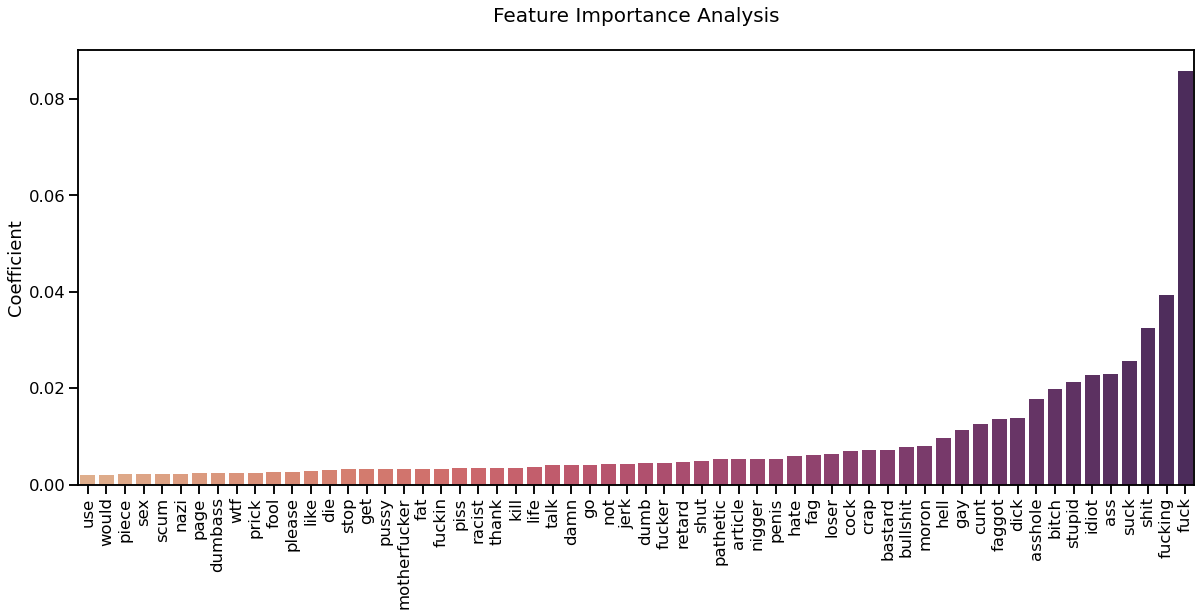

In [12]:
fig = plt.figure(figsize=(20,8))

# ax = fig.add_subplot(2,1,1)
ax = sns.barplot(x=sorted_feature_names[-60:], y=sorted_feature_importances[-60:], palette='flare')
plt.tick_params(axis='x', rotation=90)
ax.set(ylabel='Coefficient')
plt.title('Feature Importance Analysis', y=1.05, fontsize=20)
# plt.ylim([-.5,2.5])
plt.show()

The features coefficient of random forest model is calculated based on the gini to build the nodes. The features of the toxic class have a higher value compared to those for the non-toxic class.

### 3.2.2. Feature Importance Using SHAP Technique

In [64]:
feature_names = tfidf_model.get_feature_names_out()
explainer = shap.Explainer(RF, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape)

(63541, 5000, 2)


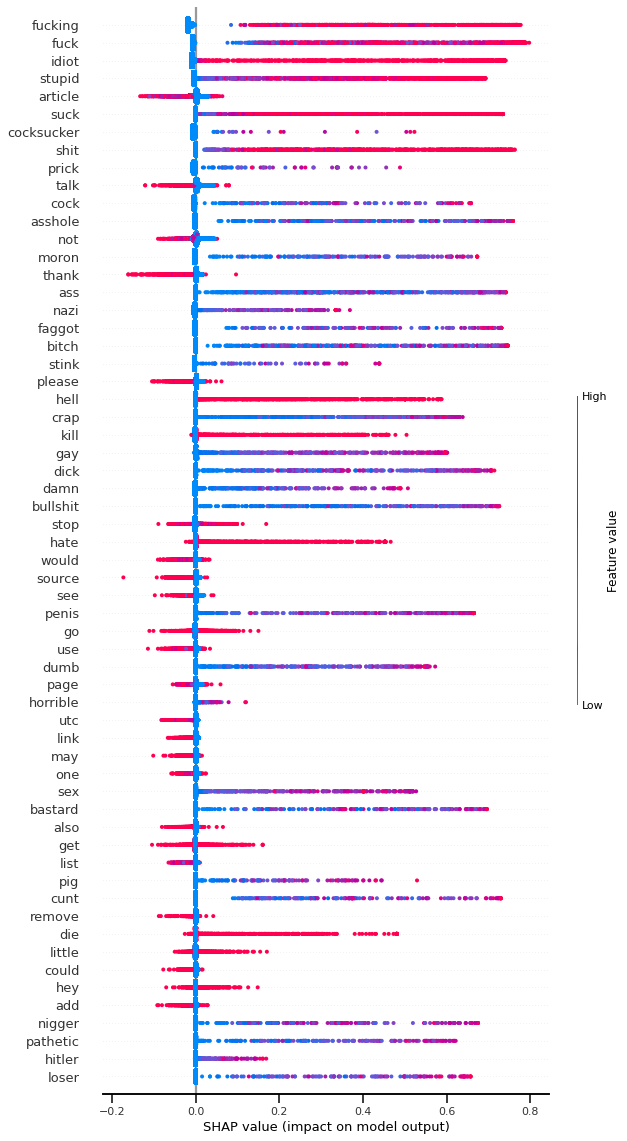

In [63]:
# SHAP Summary plot

shap.summary_plot(shap_values[:,:,1], X_test_vec, max_display=60, feature_names=feature_names, 
                  sort=True, plot_size=(10,20))

The summary plot shows that the features specifying the toxic calss have a higher SHAP values comapared to the non-toxic class. In addition, some features regardless of small feature value have a large SHAP value. In order to investigate more, the waterfall plot are displayed for some instances of both classes. 

Waterfall plot display explanations for an individual prediction. The bottom of waterfall E[f(x)] starts as the expected value of the model output. Afterwards, each row shows how the positive or negative contribution of each feature moves the value from the expected model output to the model output for this specific prediction.

mel gibson nazi bitch makes shitty movies much buttsex asshole big enough consider country
Class: 1


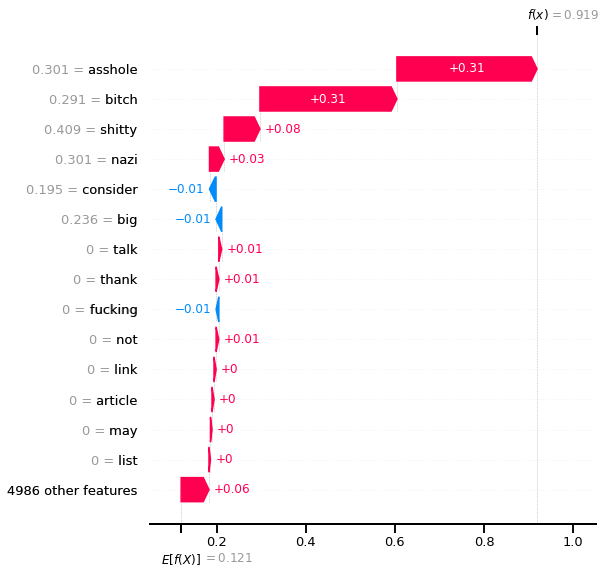

In [66]:
shap.initjs()

ind = -2
print(X_test.iloc[ind])
print('Class:', y_test.iloc[ind])

shap.plots.waterfall(shap_values[ind,:,1], max_display=15)

The waterfall plot for this toxic comment represents that the effects of "asshole", "bitch" and "shitty" features in the SHAP value for this prediction. The SHAP value of "asshole" and "bitch" is considerably larger than the SHAP value of the "shitty" feature regardless of the smaller tf-idf values.
Also, it is interesting that the zero tf-idf value of some features have a contribution.

somebody invariably try add religion really mean way people invariably keep add religion samuel beckett infobox bother bring long dead completely non existent influence issue flail make crap fly comparison explicit acknowledgement entire amos oz article personally jewish category
Class: 0


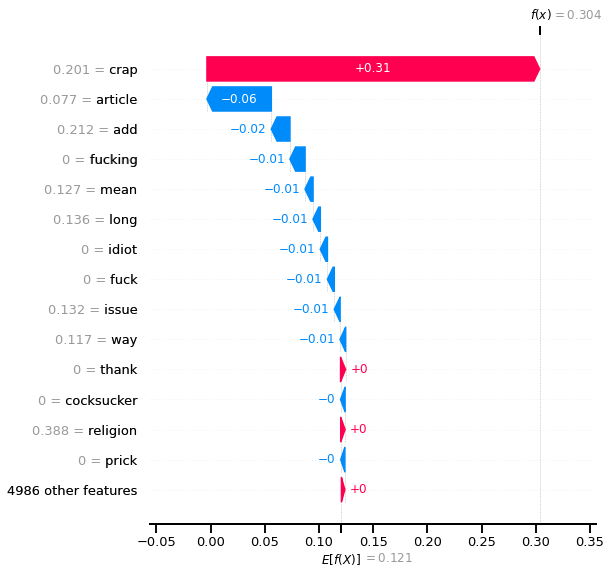

In [67]:
shap.initjs()

ind = 2
print(X_test.iloc[ind])
print('Class:', y_test.iloc[ind])

shap.plots.waterfall(shap_values[ind,:,1], max_display=15)

energy edit introduction previously say passive transport not use kind energy not true passive transport rely kinetic energy substance transport kinetic energy cause move around random chance cross membrane difference active transport actually use cell energy atp electrochemical gradient pump substance across membrane
Class: 0


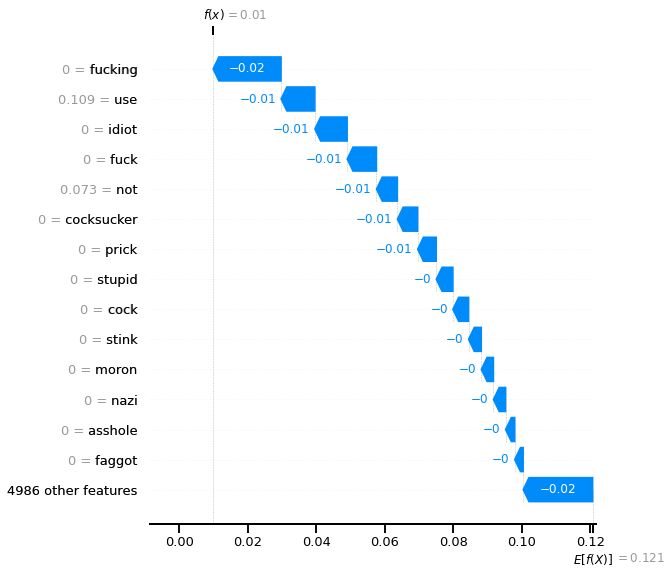

In [69]:
shap.initjs()

ind = 10
print(X_test.iloc[ind])
print('Class:', y_test.iloc[ind])

shap.plots.waterfall(shap_values[ind,:,1], max_display=15)

The waterfall plot of this non-toxic comment represents that the largest SHAP value belongs to the "fucking" feature with zero tf-idf score. It means that the model has learned to give a small shift towards the negative label when this feature is not present in the text.

arabs commit genocide iraq no protest europe may europe also burn hell
Class: 1


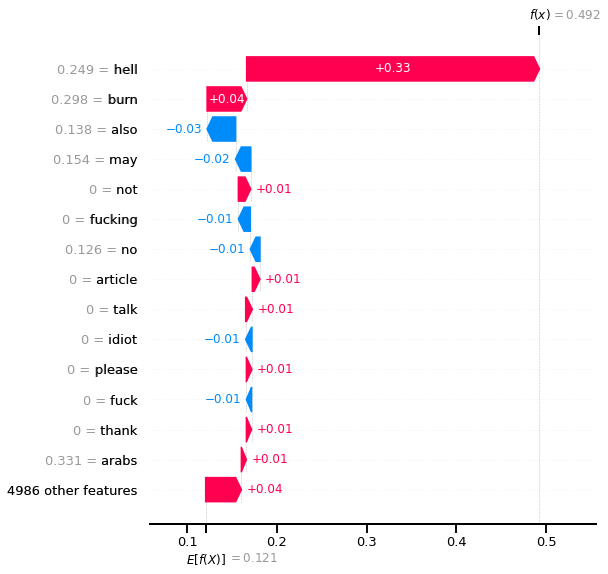

In [70]:
shap.initjs()

ind = 8
print(X_test.iloc[ind])
print('Class:', y_test.iloc[ind])

shap.plots.waterfall(shap_values[ind,:,1], max_display=15)

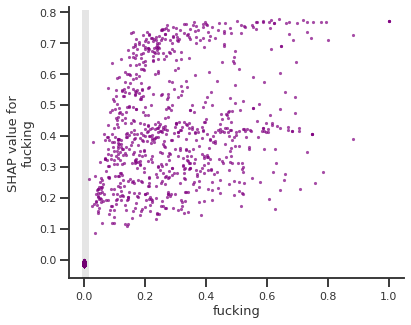

In [114]:
shap.plots.scatter(shap_values[:,"fucking",1], dot_size=10, x_jitter=1, alpha=0.7, color='purple')

In general, an increase of TF-IDF score of “fucking” feature increased the SHAP value. The abovementioned note is observed in the scatter plot. The zero TF-IDF score of this feature results in a shift towards the negative SHAP value. 

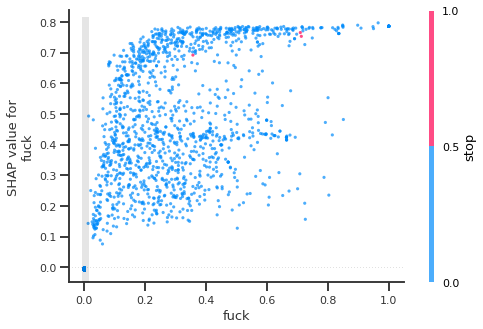

In [87]:
shap.plots.scatter(shap_values[:,"fuck",1], color=shap_values[:,"stop",1], dot_size=10, x_jitter=1, alpha=0.7)

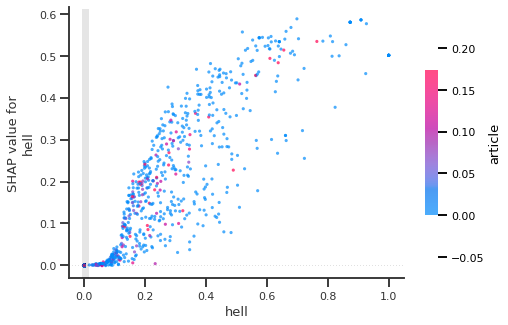

In [82]:
shap.plots.scatter(shap_values[:,"hell",1], color=shap_values[:,"article",1], dot_size=10, x_jitter=1, alpha=0.7)

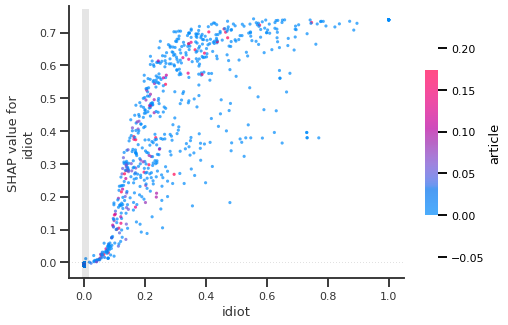

In [81]:
shap.plots.scatter(shap_values[:,"idiot",1], color=shap_values[:,"article",1], dot_size=10, x_jitter=1, alpha=0.7)

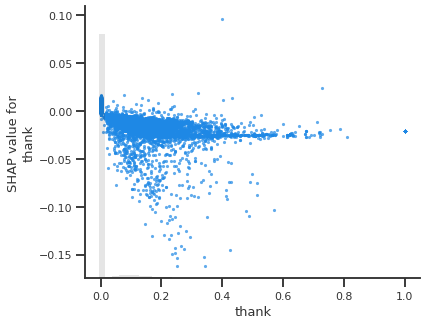

In [83]:
shap.plots.scatter(shap_values[:,"thank",1], dot_size=10, x_jitter=1, alpha=0.7)

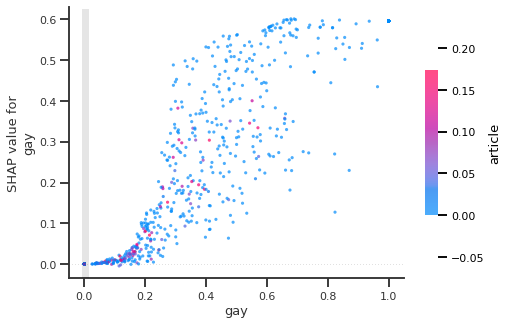

In [86]:
shap.plots.scatter(shap_values[:,"gay",1], color=shap_values[:,"article",1], dot_size=10, x_jitter=1, alpha=0.7)

## 2.4. XGBoost

In [12]:
tfidf_xg = TfidfVectorizer(max_features=4000)
tfidf_model_xg = tfidf_xg.fit(X_train)
X_train_vec_xg = tfidf_model_xg.transform(X_train).toarray()
X_test_vec_xg = tfidf_model_xg.transform(X_test).toarray()

XGB = XGBClassifier(objective='binary:logistic', seed=12, use_label_encoder=False, 
                    colsample_bytree=0.954, learning_rate=0.126,
                    max_delta_step=8, max_depth=5, n_estimators=2816,
                    subsample=0.71, n_jobs=-1)

XGB.fit(X_train_vec_xg, y_train)

[18:23:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.954,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.126, max_delta_step=8, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2816, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=12, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=12, subsample=0.71, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [13]:
feature_names_xg = tfidf_model_xg.get_feature_names_out()
explainer_xg = shap.TreeExplainer(XGB, X_train_vec_xg, feature_names=feature_names_xg)
shap_values_xg = explainer_xg(X_test_vec_xg)
print(shap_values_xg.values.shape)

100%|===================| 63523/63541 [49:55<00:00]        

(63541, 4000)


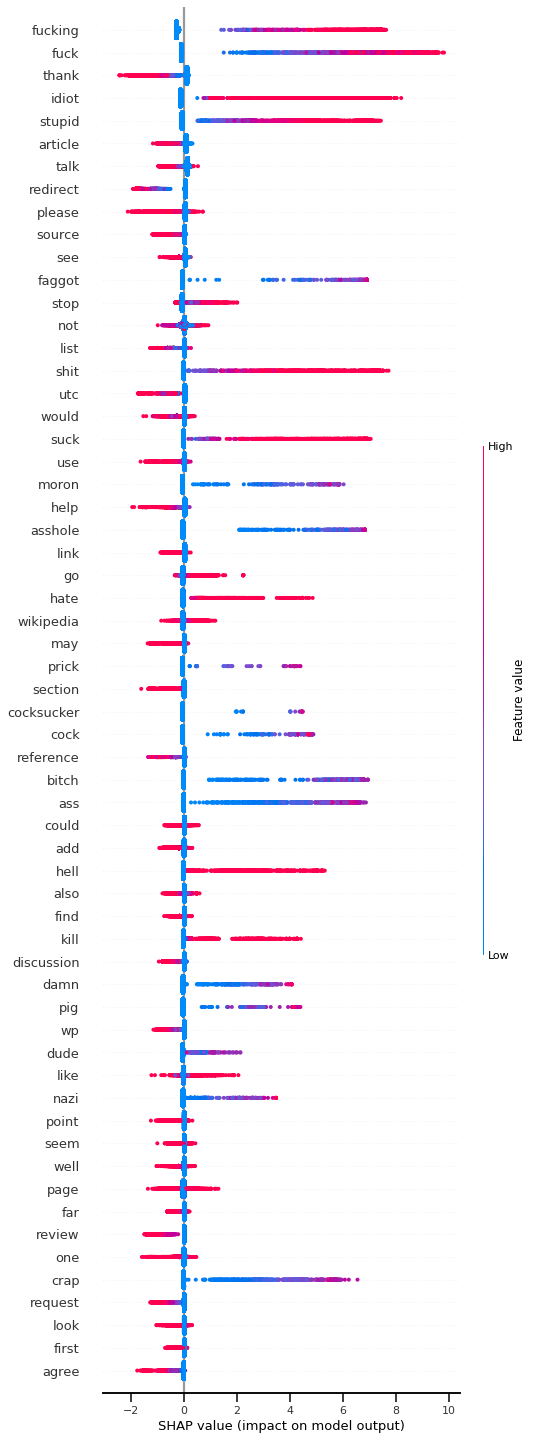

In [14]:
shap.summary_plot(shap_values_xg, X_test_vec_xg, max_display=60, feature_names=feature_names_xg, 
                 class_names=['Non-toxic', 'toxic'], class_inds='original')

mel gibson nazi bitch makes shitty movies much buttsex asshole big enough consider country
Class: 1


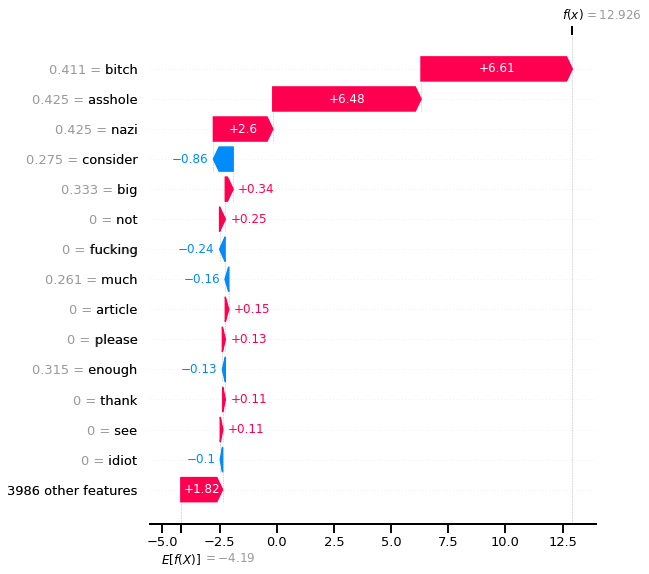

In [16]:
shap.initjs()

ind = -2
print(X_test.iloc[ind])
print('Class:', y_test.iloc[ind])

shap.plots.waterfall(shap_values_xg[ind,:], max_display=15)

somebody invariably try add religion really mean way people invariably keep add religion samuel beckett infobox bother bring long dead completely non existent influence issue flail make crap fly comparison explicit acknowledgement entire amos oz article personally jewish category
Class: 0


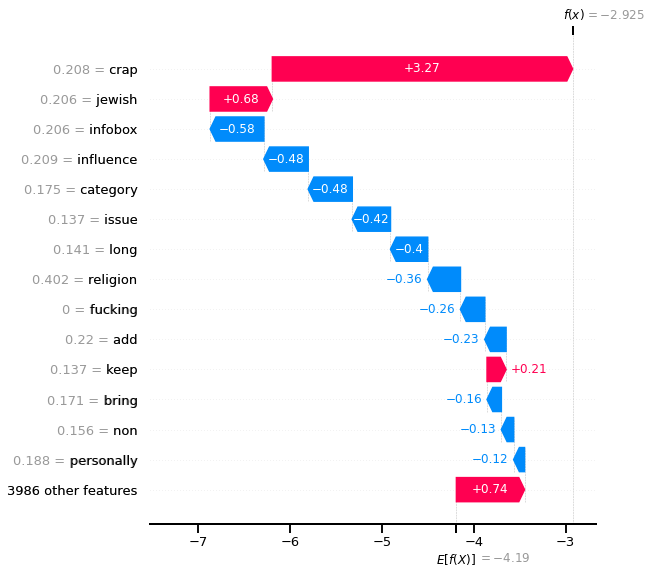

In [17]:
shap.initjs()

ind = 2
print(X_test.iloc[ind])
print('Class:', y_test.iloc[ind])

shap.plots.waterfall(shap_values_xg[ind,:], max_display=15)

energy edit introduction previously say passive transport not use kind energy not true passive transport rely kinetic energy substance transport kinetic energy cause move around random chance cross membrane difference active transport actually use cell energy atp electrochemical gradient pump substance across membrane
Class: 0


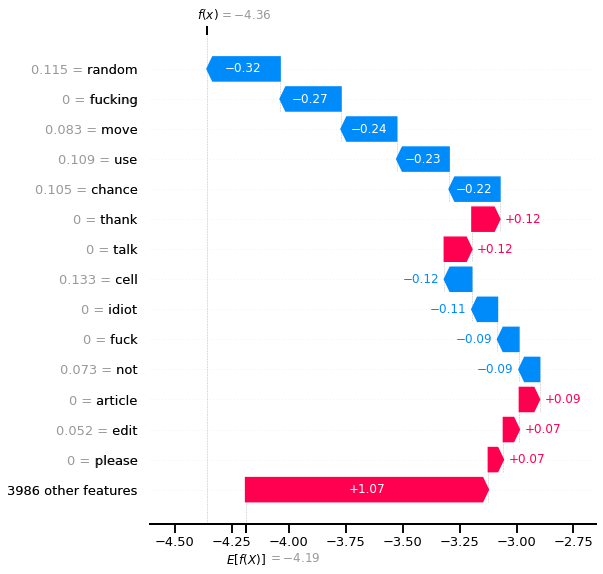

In [19]:
shap.initjs()

ind = 10
print(X_test.iloc[ind])
print('Class:', y_test.iloc[ind])

shap.plots.waterfall(shap_values_xg[ind,:], max_display=15)

arabs commit genocide iraq no protest europe may europe also burn hell
Class: 1


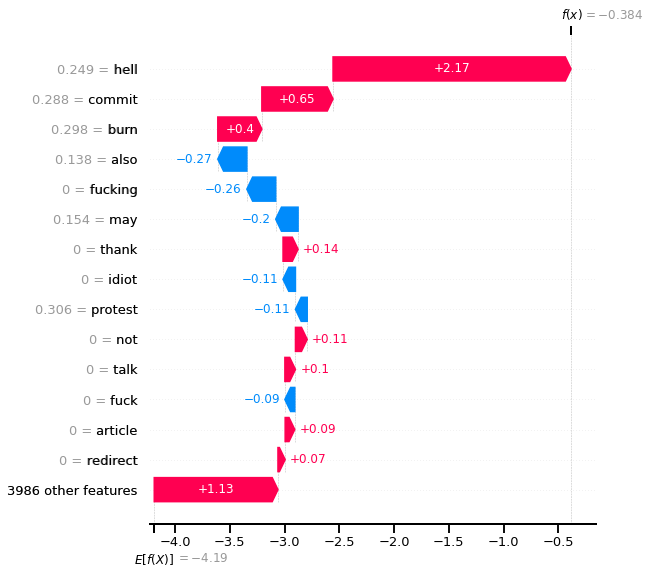

In [21]:
shap.initjs()

ind = 8
print(X_test.iloc[ind])
print('Class:', y_test.iloc[ind])

shap.plots.waterfall(shap_values_xg[ind,:], max_display=15)

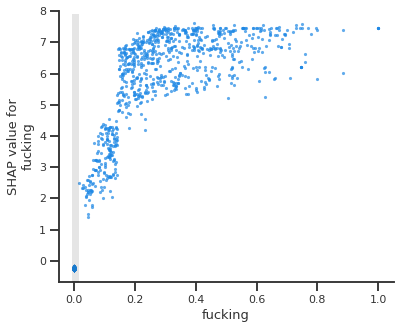

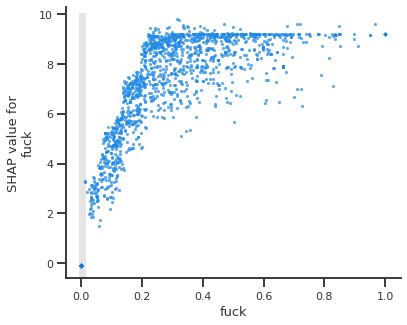

In [30]:
shap.plots.scatter(shap_values_xg[:,"fucking"], dot_size=10, x_jitter=1, alpha=0.7)
shap.plots.scatter(shap_values_xg[:,"fuck"], dot_size=10, x_jitter=1, alpha=0.7)

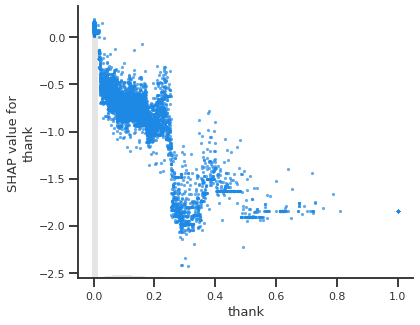

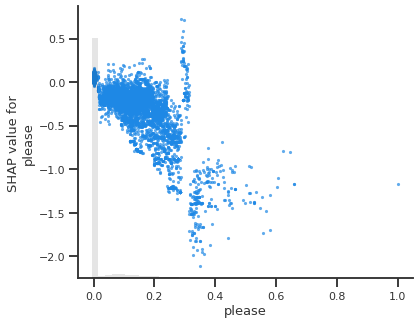

In [31]:
shap.plots.scatter(shap_values_xg[:,"thank"], dot_size=10, x_jitter=1, alpha=0.7)
shap.plots.scatter(shap_values_xg[:,"please"], dot_size=10, x_jitter=1, alpha=0.7)

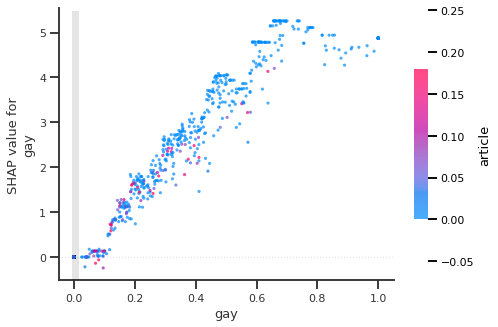

In [98]:
shap.plots.scatter(shap_values_xg[:,"gay"], color=shap_values_xg[:,"article"], dot_size=10, x_jitter=1, alpha=0.7)

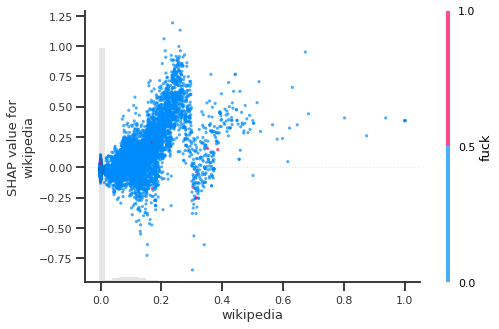

In [101]:
shap.plots.scatter(shap_values_xg[:,"wikipedia"], color=shap_values_xg[:,"fuck"], 
                   dot_size=10, x_jitter=1, alpha=0.7)

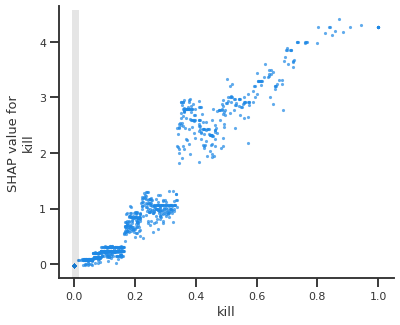

In [102]:
shap.plots.scatter(shap_values_xg[:,"kill"], dot_size=10, x_jitter=1, alpha=0.7)